# Análise Exploratória - Mapeamento de Criminalidade no Ceará

Realizar uma análise exploratória de dados (EDA) de crimes por arma de fogo, roubos e homicídios

## Importar bibliotecas

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from src.data.GraficoHelper import GraficoHelper as grh

## Carregar o dataset de 2015 até hoje, exceto os 30 dias mais recentes

In [2]:
# Separar as colunas desejáveis do conjunto de dados
colunas = ['MUNICIPIO', 'NATUREZA DO FATO', 'ARMA UTILIZADA', 'DATA DA MORTE', 'SEXO', 'IDADE']

# Carregar dataset e determinar as variáveis categóricas
df_carga = pd.read_csv(r'../data/processed/sspds-ce/dataset_consolidado.csv', sep=";", usecols=colunas, 
    dtype={
        'MUNICIPIO':'category', 'NATUREZA DO FATO':'category', 'ARMA UTILIZADA':'category', 
        'SEXO':'category', 'IDADE':'category' })

## Formatar e converter colunas

### Normalizar a coluna de Data do Óbito

In [3]:
# Dividir o dataset entre os formatos de data #1 e #2
df_data1 = pd.DataFrame(df_carga[df_carga['DATA DA MORTE'].str.contains("-")])
df_data2 = pd.DataFrame(df_carga[df_carga['DATA DA MORTE'].str.contains("/")])

# Quebrar em colunas para ajustar a formatação #1
df_data1[['D', 'M', 'Y']] = df_data1['DATA DA MORTE'].str.split('-', 2, expand=True)
df_data1['D'] = df_data1['D'].str.zfill(2)
df_data1['M'] = df_data1['M'].str.capitalize()
df_data1['M'] = df_data1['M'].replace('Fev', 'Feb').replace('Mai', 'May')
df_data1['Y'] = df_data1['Y'].replace('15', '2015')
# Concatenar o formato #1
df_data1['DATA DA MORTE'] = df_data1['D']+"-"+df_data1['M']+"-"+df_data1['Y']

# Coverter dataset formato #1
df_data1['DATA'] = pd.to_datetime(df_data1['DATA DA MORTE'], format="%d-%b-%Y")
# Coverter dataset formato #2
df_data2['DATA'] = pd.to_datetime(df_data2['DATA DA MORTE'], format="%d/%m/%Y")

# Eliminar colunas sem uso
df_data1 = df_data1.drop(columns=['D','M','Y','DATA DA MORTE'])
df_data2 = df_data2.drop(columns=['DATA DA MORTE'])

# Juntar dataframes em um novo consolidado
df_consolidado = pd.concat([df_data1, df_data2])

### Normalizar coluna IDADE

In [4]:
# Substituir valores vazios de IDADE, por NaN para o tipo categórico
df_consolidado['IDADE'] = df_consolidado['IDADE'].replace('-', np.nan)
df_consolidado['IDADE'] = df_consolidado['IDADE'].astype('category')
df_consolidado['IDADE'].unique() # Identificar

['26', '18', '35', NaN, '13', ..., '90', '6', '91', '94', '86']
Length: 95
Categories (94, object): ['0', '1', '10', '11', ..., '90', '91', '93', '94']

### Normalizar coluna NATUREZA DO FATO

In [5]:
# Verificar campos únicos de NATUREZA DO FATO, para formata-los
df_consolidado['NATUREZA DO FATO'] = df_consolidado['NATUREZA DO FATO'].replace('FEMINICÍDIO','FEMINICIDIO')
df_consolidado['NATUREZA DO FATO'] = df_consolidado['NATUREZA DO FATO'].replace('LESÃO CORPORAL SEGUIDA DE MORTE', 'LESAO CORPORAL SEGUIDA DE MORTE').replace('LESÃO CORPORAL SEGUIDO DE MORTE', 'LESAO CORPORAL SEGUIDA DE MORTE')
df_consolidado['NATUREZA DO FATO'] = df_consolidado['NATUREZA DO FATO'].astype('category')
df_consolidado['NATUREZA DO FATO'].unique() # Identificar

['HOMICIDIO DOLOSO', 'ROUBO SEGUIDO DE MORTE (LATROCINIO)', 'LESAO CORPORAL SEGUIDA DE MORTE', NaN, 'FEMINICIDIO', 'MORTE SUSPEITA']
Categories (5, object): ['FEMINICIDIO', 'HOMICIDIO DOLOSO', 'LESAO CORPORAL SEGUIDA DE MORTE', 'MORTE SUSPEITA', 'ROUBO SEGUIDO DE MORTE (LATROCINIO)']

### Normalizar coluna SEXO

In [6]:
# Verificar campos únicos de SEXO, para formata-los
df_consolidado['SEXO'] = df_consolidado['SEXO'].replace('-', np.nan)
df_consolidado['SEXO'] = df_consolidado['SEXO'].str.upper()
df_consolidado['SEXO'] = df_consolidado['SEXO'].replace('FEMININO','F').replace('FEMININO ','F').replace('F ','F')
df_consolidado['SEXO'] = df_consolidado['SEXO'].replace('MASCULINO','M').replace('MASCULINO ','M').replace('M ','M')
df_consolidado['SEXO'] = df_consolidado['SEXO'].replace('NÃO IDENTIFICADO', 'NAO IDENTIFICADO')
df_consolidado['SEXO'] = df_consolidado['SEXO'].replace('NÃO INFORMADO','NAO INFORMADO')
df_consolidado['SEXO'] = df_consolidado['SEXO'].astype('category')
df_consolidado['SEXO'].unique() # Identificar

['M', 'F', 'I', NaN, 'NAO IDENTIFICADO', 'NI', 'NAO INFORMADO']
Categories (6, object): ['F', 'I', 'M', 'NAO IDENTIFICADO', 'NAO INFORMADO', 'NI']

### Normalizar coluna ARMA UTILIZADA

In [7]:
# Verificar o campo ARMA UTILIZADA por valores únicos
df_consolidado['ARMA UTILIZADA'] = df_consolidado['ARMA UTILIZADA'].str.upper()
df_consolidado['ARMA UTILIZADA'] = df_consolidado['ARMA UTILIZADA'].replace('OUTROS MEIOS', 'OUTROS').replace('ARMA OUTROS', 'OUTROS').replace('AMA OUTROS', 'OUTROS').replace('OUTRO', 'OUTROS')
df_consolidado['ARMA UTILIZADA'] = df_consolidado['ARMA UTILIZADA'].replace('NÃO INFORMAD', 'NI').replace('MEIO NÃO INFORMADO', 'NI').replace('NÃO INFORMADO', 'NI')
df_consolidado['ARMA UTILIZADA'] = df_consolidado['ARMA UTILIZADA'].replace('ARAMA BRANCA', 'ARMA BRANCA').replace('ARAMA DE BRANCA', 'ARMA BRANCA').replace('ARMA DE BRANCA', 'ARMA BRANCA')
df_consolidado['ARMA UTILIZADA'] = df_consolidado['ARMA UTILIZADA'].replace('ARMADE FOGO', 'ARMA DE FOGO').replace('ARAMA DE FOGO', 'ARMA DE FOGO')
df_consolidado['ARMA UTILIZADA'] = df_consolidado['ARMA UTILIZADA'].astype('category')
df_consolidado['ARMA UTILIZADA'].unique() # Identificar

['ARMA DE FOGO', 'ARMA BRANCA', 'OUTROS', 'NI', NaN]
Categories (4, object): ['ARMA BRANCA', 'ARMA DE FOGO', 'NI', 'OUTROS']

### Normalizar coluna MUNICIPIO

In [8]:
# Normalizar os nomes dos municípios
df_consolidado['MUNICIPIO'] = df_consolidado['MUNICIPIO'].str.upper()
df_consolidado['MUNICIPIO'] = df_consolidado['MUNICIPIO'].apply( lambda a: a.replace('Ç','C').replace('Á','A').replace('É','E').replace('Í','I').replace('Ó','O').replace('Ú','U').replace('Ã','A').strip() )
df_consolidado['MUNICIPIO'] = df_consolidado['MUNICIPIO'].replace('-', np.nan)
df_consolidado['MUNICIPIO'] = df_consolidado['MUNICIPIO'].astype('category') # converter em categórica
df_consolidado['MUNICIPIO'].unique() # Identificar

['FORTALEZA', 'BREJO SANTO', 'MARACANAU', 'ITAPIUNA', 'CRATEUS', ..., 'JATI', 'IPAPORANGA', 'MARTINOPOLE', 'JAGUARIBARA', 'MERUOCA']
Length: 186
Categories (185, object): ['ABAIARA', 'ACARAPE', 'ACARAU', 'ACOPIARA', ..., 'URUOCA', 'VARJOTA', 'VARZEA ALEGRE', 'VICOSA DO CEARA']

## Prévia e informações preliminares sobre o Dataset

In [9]:
# Prévia dos dados
df_consolidado.head(5)

,MUNICIPIO,NATUREZA DO FATO,ARMA UTILIZADA,SEXO,IDADE,DATA
0,FORTALEZA,HOMICIDIO DOLOSO,ARMA DE FOGO,M,26,2015-12-01
1,BREJO SANTO,HOMICIDIO DOLOSO,ARMA BRANCA,M,18,2015-12-01
2,FORTALEZA,HOMICIDIO DOLOSO,ARMA DE FOGO,M,35,2015-12-01
3,MARACANAU,HOMICIDIO DOLOSO,ARMA DE FOGO,M,NaN,2015-12-01
4,FORTALEZA,HOMICIDIO DOLOSO,ARMA DE FOGO,M,13,2015-12-01


In [10]:
# Informações preliminares sobre o dataset
print('Quantidade de linhas e colunas:', df_consolidado.shape)
print('Quantidade total de dados nulos:', df_consolidado.isna().sum().sum())

Quantidade de linhas e colunas: (25888, 6)
Quantidade total de dados nulos: 1432


In [11]:
# Tipo de dados
df_consolidado.dtypes

MUNICIPIO                 category
NATUREZA DO FATO          category
ARMA UTILIZADA            category
SEXO                      category
IDADE                     category
DATA                datetime64[ns]
dtype: object

### Onde estão os dados nulos?

In [12]:
df_consolidado.isna().sum()

MUNICIPIO              1
NATUREZA DO FATO       9
ARMA UTILIZADA        54
SEXO                   6
IDADE               1362
DATA                   0
dtype: int64

## Série temporal de crimes relatados

#### Cada registro, mesmo diário, representa um crime relatado

## Visão diária dos crimes

In [13]:
df_periodo_ocorrencias = df_consolidado[['DATA', 'IDADE']]
df_serie_temp = df_periodo_ocorrencias.groupby('DATA').size().to_frame('QDE').reset_index()
df_serie_temp.head(5)

,DATA,QDE
0,2015-01-01,18
1,2015-01-02,14
2,2015-01-03,11
3,2015-01-04,16
4,2015-01-05,13


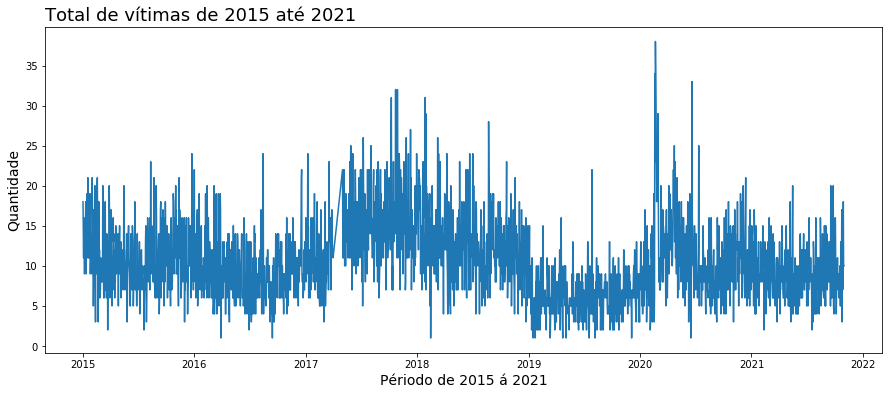

In [14]:
plt.figure(figsize=(15,6))
g = sns.lineplot(data=df_serie_temp,
            x = 'DATA',
            y = 'QDE'
            )
g.set_title('Total de vítimas de 2015 até 2021', loc='left', size=18)
g.set_xlabel('Périodo de 2015 á 2021', fontsize=14)
g.set_ylabel('Quantidade', fontsize=14)
plt.show()

## Visão mensal dos crimes

In [15]:
# Agrupar por mês em novo Dataframe
agrupamento_periodo_ocorrencias_mes = df_serie_temp.resample('M', on='DATA')
df_periodo_ocorrencias_mes = pd.DataFrame()
df_periodo_ocorrencias_mes['QDE'] = agrupamento_periodo_ocorrencias_mes['QDE'].sum()
df_periodo_ocorrencias_mes = df_periodo_ocorrencias_mes.reset_index()
df_periodo_ocorrencias_mes.head(5)

,DATA,QDE
0,2015-01-31,433
1,2015-02-28,334
2,2015-03-31,323
3,2015-04-30,329
4,2015-05-31,324


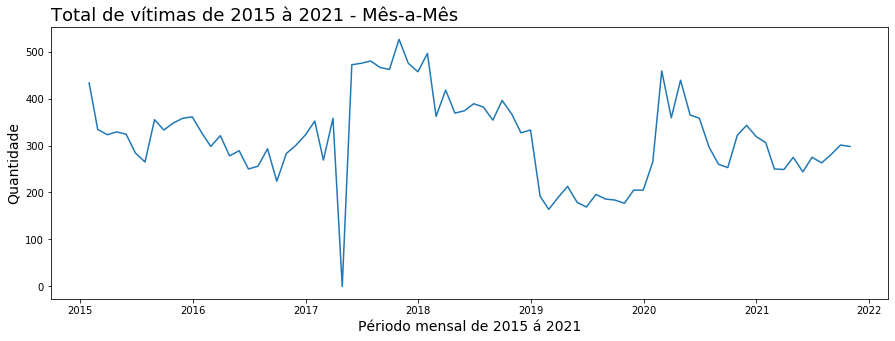

In [16]:
plt.figure(figsize=(15,5))
g = sns.lineplot(data=df_periodo_ocorrencias_mes,
            x = 'DATA',
            y = 'QDE'
            )
g.set_title('Total de vítimas de 2015 à 2021 - Mês-a-Mês', loc='left', size=18)
g.set_xlabel('Périodo mensal de 2015 á 2021', fontsize=14)
g.set_ylabel('Quantidade', fontsize=14)
plt.show()

In [17]:
# Detalhar as estatísticas de total de crimes baseada na quantidade de relatos
df_periodo_ocorrencias_mes.describe()

,QDE
count,82.000000
mean,315.707317
std,93.253602
min,0.000000
25%,260.750000
50%,321.500000
75%,361.750000
max,526.000000


## Agrupar ocorrências por sexo das vítimas

In [18]:
df_grupo_sexo = df_consolidado.groupby('SEXO').size().to_frame('TOTAL').reset_index()
df_grupo_sexo = df_grupo_sexo.sort_values(by=['TOTAL'], ascending=False)
df_grupo_sexo

,SEXO,TOTAL
2,M,23759
0,F,2105
1,I,11
3,NAO IDENTIFICADO,5
4,NAO INFORMADO,1
5,NI,1


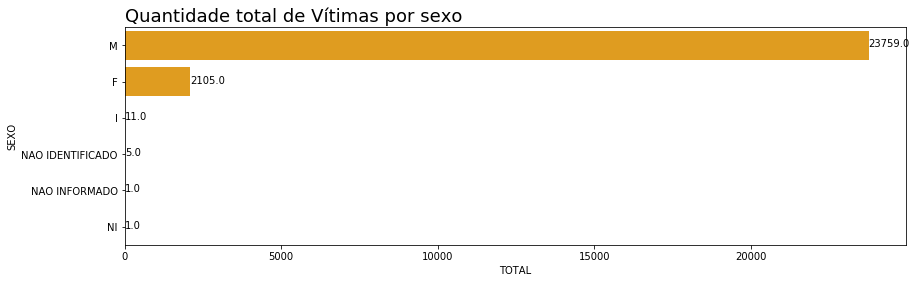

In [19]:
plt.figure(figsize=(14,4))
g = sns.barplot(data=df_grupo_sexo,
            x = 'TOTAL',
            y = 'SEXO',
            color='orange',
            order=df_grupo_sexo['SEXO']
            )
g.set_title('Quantidade total de Vítimas por sexo', loc='left', size=18)
grh.exibirValores(g, 'h')
plt.show()

## Agrupar por Município

### Visão geral

In [20]:
df_vitimas_por_municipio = df_consolidado.groupby('MUNICIPIO').size().to_frame('TOTAL').reset_index()
df_vitimas_por_municipio = df_vitimas_por_municipio.sort_values(by=['TOTAL'], ascending=False).head(50)
df_vitimas_por_municipio.head(5)

,MUNICIPIO,TOTAL
58,FORTALEZA,8645
43,CAUCAIA,1895
103,MARACANAU,1246
98,JUAZEIRO DO NORTE,726
167,SOBRAL,663


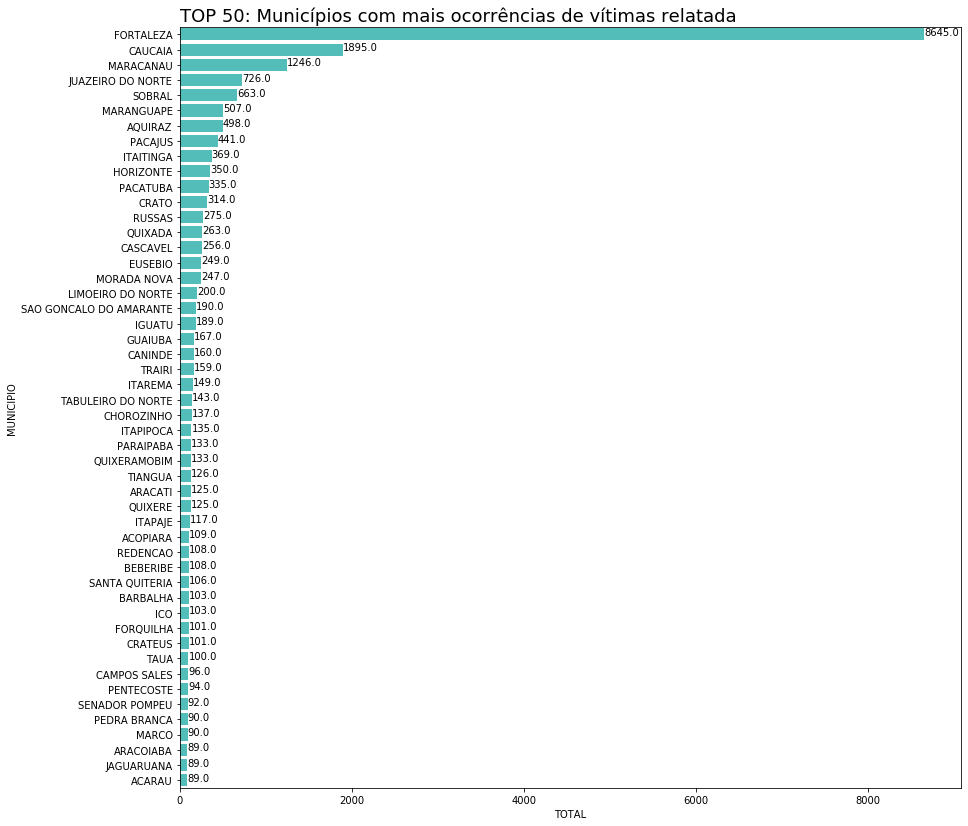

In [21]:
plt.figure(figsize=(14,14))
g = sns.barplot(data=df_vitimas_por_municipio,
            x = 'TOTAL',
            y = 'MUNICIPIO',
            color='#42cecb',
            order=df_vitimas_por_municipio['MUNICIPIO']
            )
g.set_title('TOP 50: Municípios com mais ocorrências de vítimas relatada', loc='left', size=18)
grh.exibirValores(g, 'h')
plt.show()

### Por vítimas homem

In [22]:
df_vitimas_sexo_x_municipio = df_consolidado[ df_consolidado['SEXO']=='M' ].groupby(['MUNICIPIO','SEXO']).size().to_frame('TOTAL').reset_index()
df_vitimas_sexo_x_municipio = df_vitimas_sexo_x_municipio.sort_values(by=['TOTAL'], ascending=False).head(50)
df_vitimas_sexo_x_municipio.head(5)

,MUNICIPIO,SEXO,TOTAL
350,FORTALEZA,M,7953
260,CAUCAIA,M,1688
620,MARACANAU,M,1161
590,JUAZEIRO DO NORTE,M,678
1004,SOBRAL,M,612


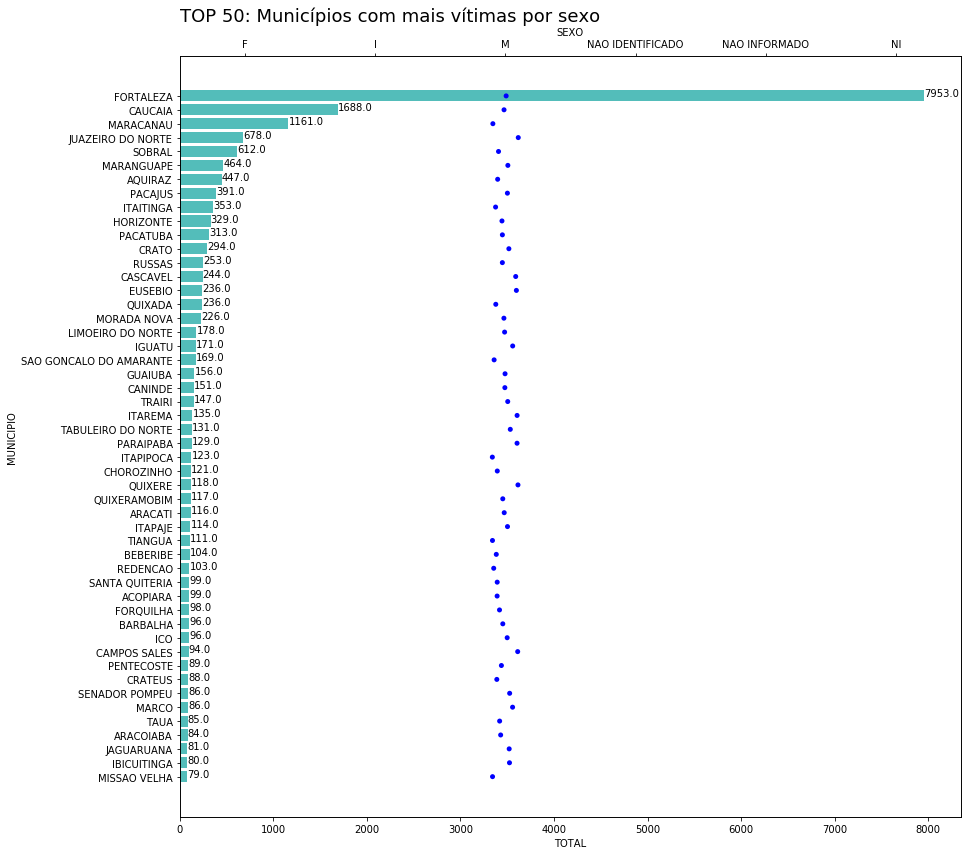

In [23]:
# exibir gráfico
plt.figure(figsize=(14,14))
g = sns.barplot(data=df_vitimas_sexo_x_municipio,
            x = 'TOTAL',
            y = 'MUNICIPIO',
            color='#42cecb',
            order=df_vitimas_sexo_x_municipio['MUNICIPIO']
            )
g.set_title('TOP 50: Municípios com mais vítimas por sexo', loc='left', size=18)
grh.exibirValores(g, 'h')

# exibir a outra coluna
ax2 = g.twiny()
sns.stripplot(x='SEXO', y='MUNICIPIO', data=df_vitimas_sexo_x_municipio, marker='o', color='blue', lw=5, ax=ax2)

plt.show()

### Por vítimas mulher

In [24]:
df_vitimas_sexo_f_municipio = df_consolidado[ df_consolidado['SEXO']=='F' ].groupby(['MUNICIPIO','SEXO']).size().to_frame('TOTAL').reset_index()
df_vitimas_sexo_f_municipio = df_vitimas_sexo_f_municipio.sort_values(by=['TOTAL'], ascending=False).head(50)
df_vitimas_sexo_f_municipio.head(5)

,MUNICIPIO,SEXO,TOTAL
348,FORTALEZA,F,687
258,CAUCAIA,F,205
618,MARACANAU,F,85
66,AQUIRAZ,F,51
1002,SOBRAL,F,50


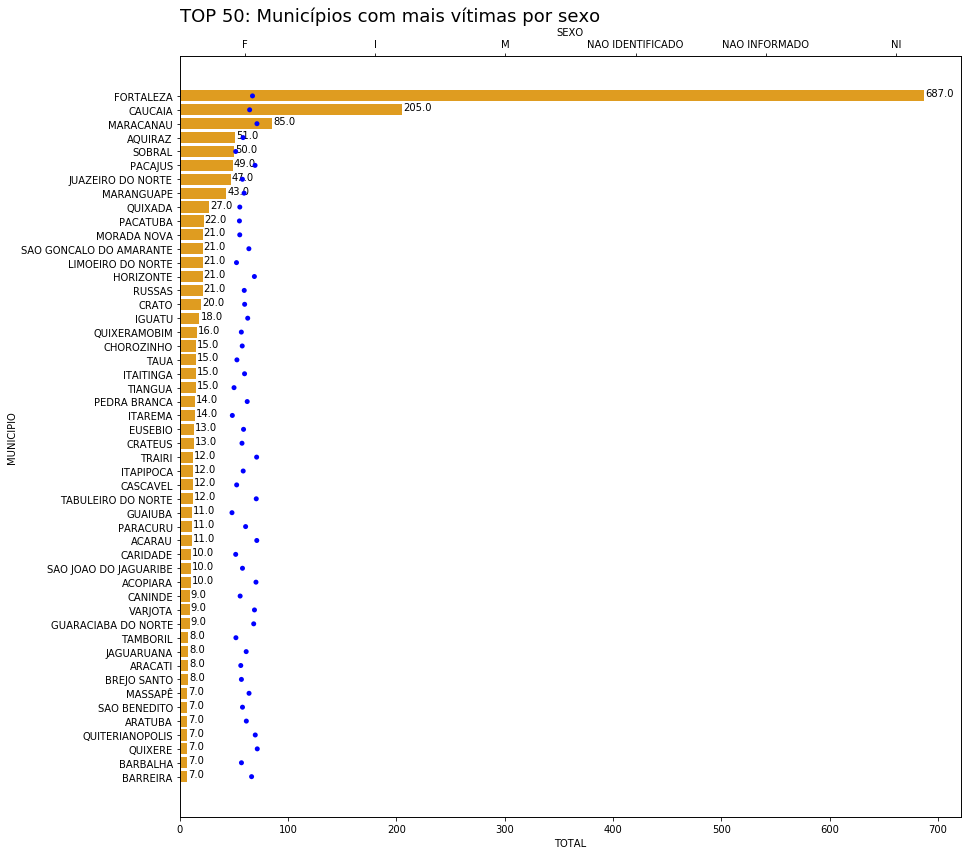

In [25]:
plt.figure(figsize=(14,14))
g = sns.barplot(data=df_vitimas_sexo_f_municipio,
            x = 'TOTAL',
            y = 'MUNICIPIO',
            color='orange',
            order=df_vitimas_sexo_f_municipio['MUNICIPIO']
            )
g.set_title('TOP 50: Municípios com mais vítimas por sexo', loc='left', size=18)
grh.exibirValores(g, 'h')

# exibir a outra coluna
ax2 = g.twiny()
sns.stripplot(x='SEXO', y='MUNICIPIO', data=df_vitimas_sexo_f_municipio, marker='o', color='blue', lw=5, ax=ax2)

plt.show()